# Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy.stats # For finding skew in the dataset

import warnings
warnings.filterwarnings('ignore')

# Read in Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Unpickle preprocessed training data

df_train = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/ames-housing/Data/train_preprocessed.pkl')
df_test = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/ames-housing/Data/test_preprocessed.pkl')
df_all = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/ames-housing/Data/all_preprocessed.pkl')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Understanding Features

Move to section below feat engg

In [3]:
def heatmap(corr_matrix):
  sns.clustermap(corr_matrix,
                 annot=False,
                 cmap='Blues')
  plt.show()

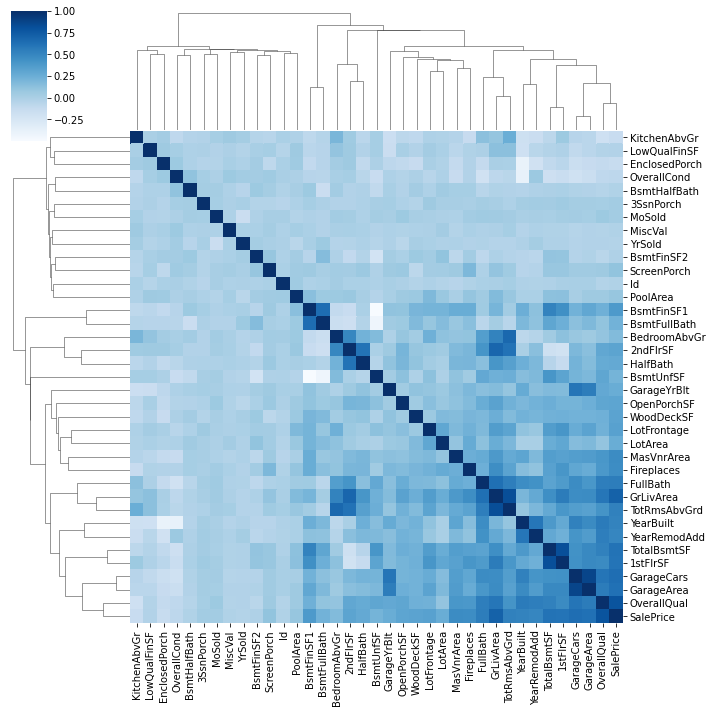

In [4]:
corr1 = df_train.corr()
heatmap(corr1)

This is a lot to look at. Instead find the features that are most strongly correlated to 'SalePrice'

In [5]:
corr2 = df_train.corr()['SalePrice'].sort_values(ascending=False)
corr2

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.334771
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
GarageYrBlt      0.261366
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

# Feature generation

Some features are overly granular. We can combine these features into a single feature.

* We have seen through EDA that unfinished vs finished surface areas matter less than total surface areas. So keep `'TotalBsmtSF'` and drop `'BsmtFinSF1'`, `'BsmtFinSF2'`, `'BsmtUnfSF'`

* Keep `'GrLivArea'` and drop `'1stFlrSF'`, `'2ndFlrSF'`, `'LowQualFinSF'`.
  * We can also retain `'2ndFlrSF'` by making a new binary variable `'Has2ndFlr'`

* Combine `'BsmtFullBath'` and `'BsmtHalfBath'` into `'BsmtTotalBath'`

* Combine `'FullBath'` and `'HalfBath'` into `'AbvGrTotalBath'`

* Combine `'WoodDeckSF'`, `'OpenPorchSF'`, `'EnclosedPorch'`, `'3SsnPorch'`, `'ScreenPorch'` into `'TotalPorchAr'`

* Note: No changes to features related to the garage

In [6]:
# Take a look at all the columns again

df_all.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
# How are the surface area variables related?

df_all[df_all['LowQualFinSF'] != 0][['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF','1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea']].head()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea
51,0.0,0.0,816.0,816.0,816,0,360,1176
88,0.0,0.0,1013.0,1013.0,1013,0,513,1526
125,490.0,0.0,30.0,520.0,520,0,234,754
170,360.0,0.0,360.0,720.0,854,0,528,1382
185,0.0,0.0,1107.0,1107.0,1518,1518,572,3608


In [8]:
# How are number of bathroom variables related?

df_all[['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']]. head()

,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath
0,1.0,0.0,2,1
1,0.0,1.0,2,0
2,1.0,0.0,2,1
3,1.0,0.0,1,0
4,1.0,0.0,2,1


In [9]:
# What is the total porch area for the home?

df_all[['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']].head()

,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch
0,0,61,0,0,0
1,298,0,0,0,0
2,0,42,0,0,0
3,0,35,272,0,0
4,192,84,0,0,0


In [10]:
# Can we feature engineer features related to the garage?

df_all[['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']].head()

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
0,Attchd,2003.0,RFn,2.0,548.0,TA,TA
1,Attchd,1976.0,RFn,2.0,460.0,TA,TA
2,Attchd,2001.0,RFn,2.0,608.0,TA,TA
3,Detchd,1998.0,Unf,3.0,642.0,TA,TA
4,Attchd,2000.0,RFn,3.0,836.0,TA,TA


# Feature transformations (for numeric features)

EDA revealed that many features were skewed (i.e. not normally distributed). Here we will use scipy.stats to figure out which features are skewed and apply a log transform to reduce the skew

In [11]:
def find_skew(dataset, show=True, col_names=False):
  df_skew = pd.DataFrame(dataset.select_dtypes(np.number).columns, columns=['Feature'])
  df_skew['Skew'] = df_skew['Feature'].apply(lambda feature: scipy.stats.skew(dataset[feature]))
  df_skew['Absolute Skew'] = df_skew['Skew'].apply(abs)
  df_skew['Skewed'] = df_skew['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)

  if show:
    from IPython.display import display
    display(df_skew)

  if col_names:
    return df_skew[df_skew['Absolute Skew'] >= 0.5]['Feature'].values

find_skew(df_all)

,Feature,Skew,Absolute Skew,Skewed
0,Id,0.000000,0.000000,False
1,LotFrontage,1.652671,1.652671,True
2,LotArea,12.822431,12.822431,True
3,OverallQual,0.197110,0.197110,False
4,OverallCond,0.570312,0.570312,True
5,YearBuilt,-0.599806,0.599806,True
6,YearRemodAdd,-0.451020,0.451020,False
7,MasVnrArea,2.613592,2.613592,True
8,BsmtFinSF1,1.425230,1.425230,True
9,BsmtFinSF2,4.146143,4.146143,True


In [12]:
df1 = df_all.copy()
skewed_cols = find_skew(df1, show=False, col_names=True)

for col in skewed_cols:
  df1[col] = np.log1p(df1[col])

find_skew(df1)

,Feature,Skew,Absolute Skew,Skewed
0,Id,0.000000,0.000000,False
1,LotFrontage,-1.013789,1.013789,True
2,LotArea,-0.504751,0.504751,True
3,OverallQual,0.197110,0.197110,False
4,OverallCond,-0.746183,0.746183,True
5,YearBuilt,-0.626215,0.626215,True
6,YearRemodAdd,-0.451020,0.451020,False
7,MasVnrArea,0.537018,0.537018,True
8,BsmtFinSF1,-0.616632,0.616632,True
9,BsmtFinSF2,2.462483,2.462483,True


Some features are still skewed but we have reduced the skew in most of them. For example, the skew for `'LotArea'` went from 12.8 to 0.5.

In [13]:
del df1

# Feature encoding (for categorical features)

There are many categorical variables in this dataset. We will first check if both the test and train sets have the same values in all the categorical variables. This is necessary to ensure the train and test sets get encoded properly. In a real world setting, we need to do our best to ensure that the train set is completely representative of the test set. 

* Below is one example of the feature `'Electrical'` where the train set and test set do not have the same number of values

* The best way to avoid this is go back to our preprocessing step and create a combined dataset, and later separate it again into the original train and test sets after feature engineering

* This will ensure that both the train and test sets will have the same features after encoding

* We will use `pd.get_dummies()` to automatically select and encode the categorical features

In [14]:
print("Train set:")
print(df_train['Electrical'].value_counts())
print("\nTest set:")
print(df_test['Electrical'].value_counts())

Train set:
SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

Test set:
SBrkr    1337
FuseA      94
FuseF      23
FuseP       5
Name: Electrical, dtype: int64


In [15]:
# Encode features into temporary dataframes to confirm encoding is as we expect
df1 = pd.get_dummies(df_all)
df2 = pd.get_dummies(df_all, drop_first=True)

print(df_all.shape)
print(df1.shape)
print(df2.shape)

(2919, 80)
(2919, 318)
(2919, 274)


In [16]:
del df1
del df2

# Create EngineerFeatures object

In [17]:
class EngineerFeatures():

  def __init__(self):
    pass

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None): 
    X_new = X.copy()

    # Feature generation

    X_new['BsmtTotalBath'] = X_new['BsmtFullBath'] + (0.5 * X_new['BsmtHalfBath'])
    X_new['AbvGrTotalBath'] = X_new['FullBath'] + (0.5 * X_new['HalfBath'])
    X_new['TotalPorchAr'] = X_new['WoodDeckSF'] + X_new['OpenPorchSF'] + X_new['EnclosedPorch'] + X_new['3SsnPorch'] + X_new['ScreenPorch'] 
    X_new['Has2ndFlr'] = X_new['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

    cols_to_drop = [
        'BsmtFinSF1', 
        'BsmtFinSF2', 
        'BsmtUnfSF',
        '1stFlrSF', 
        '2ndFlrSF', 
        'LowQualFinSF', 
        'BsmtFullBath', 
        'BsmtHalfBath', 
        'FullBath', 
        'HalfBath', 
        'WoodDeckSF', 
        'OpenPorchSF', 
        'EnclosedPorch', 
        '3SsnPorch', 
        'ScreenPorch'
    ]

    X_new = X_new.drop(cols_to_drop, axis=1)


    # Feature trasnformations for numeric features
    
    skewed_cols = find_skew(X_new, show=False, col_names=True)

    for col in skewed_cols:
      X_new[col] = np.log1p(X_new[col])


    # Feature selection


    # Feature encoding

    X_new = pd.get_dummies(X_new, drop_first=True)


    return X_new

  def fit_transform(self, X, y=None):
    return self.fit(X).transform(X)

In [18]:
engg = EngineerFeatures()

df_all = engg.fit_transform(df_all)

df_all.columns

Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=263)

In [19]:
df_train_engineered = df_all[:1460]

In [20]:
df_test_engineered = df_all[1460:]

In [21]:
print(df_all.shape)
print(df_train.shape)
print(df_train_engineered.shape)
print(df_test.shape)
print(df_test_engineered.shape)

(2919, 263)
(1460, 81)
(1460, 263)
(1459, 80)
(1459, 263)


# Target transformation

Also important is to check whether the target variable is normally distributed, and if not, to transform it so it is closer to being normally distributed. 
* Let's first get the target variable and plot it.
* Then we can use the fit feature of a distplot to see how closely the target variable fits a normal distribution
* Then we can do the same with a log transformed target variable and look at the results


We can see in the plots below that the transformed SalePrice is much closer to being normally distributed. We will save the transformed target variable as a pickle file for future use. 

In [22]:
target = df_train['SalePrice']
log_target = np.log(target)

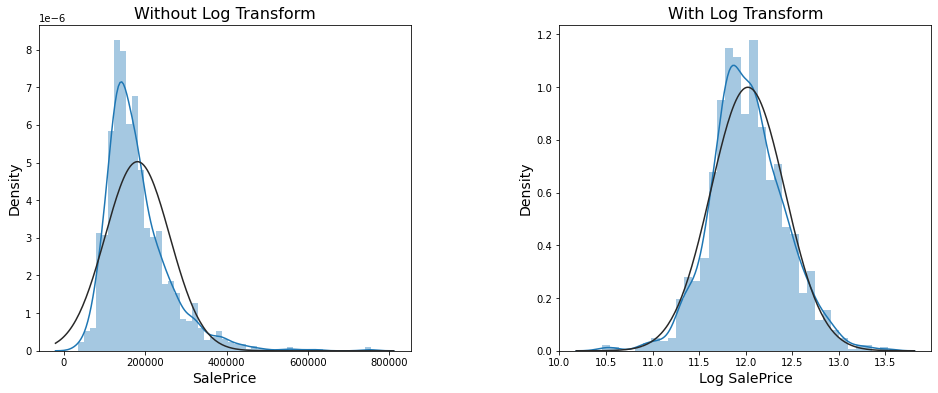

In [23]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.distplot(target, fit=scipy.stats.norm)
plt.xlabel('SalePrice', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Without Log Transform', fontsize=16)

plt.subplot(1, 2, 2)
sns.distplot(log_target, fit=scipy.stats.norm)
plt.xlabel('Log SalePrice', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('With Log Transform', fontsize=16)
plt.subplots_adjust(wspace=.4)

# Save engineered/transformed data

In [24]:
df_train_engineered.to_pickle('/content/drive/MyDrive/Colab Notebooks/ames-housing/Data/train_transformed.pkl')
df_test_engineered.to_pickle('/content/drive/MyDrive/Colab Notebooks/ames-housing/Data/test_transformed.pkl')
log_target.to_pickle('/content/drive/MyDrive/Colab Notebooks/ames-housing/Data/target_transformed.pkl')